# Banking Sales Dataset - A logistic regression analysis

Exercise: The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y, "Festgeld").

**Predict variable (desired target):**
- y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

**Input variables:**
1. age (numeric)
2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
4. education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
5. default: has credit in default? (categorical: “no”, “yes”, “unknown”)
6. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
7. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
8. contact: contact communication type (categorical: “cellular”, “telephone”)
9. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
10. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
11. duration: last contact duration, in seconds (numeric). 
    - <span style="color:red">Important note: </span>this attribute highly affects the output target (e.g., if duration=0 then y=‘no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
16. emp.var.rate: employment variation rate — (numeric)
17. cons.price.idx: consumer price index — (numeric)
18. cons.conf.idx: consumer confidence index — (numeric)
19. euribor3m: euribor 3 month rate — (numeric)
20. nr.employed: number of employees — (numeric)

---
## 1) Import Packages and Dataset

In [181]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # to ignore seaborn warnings
pd.set_option("display.max_columns", 50)

In [182]:
# Import dataset

url = 'https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv'
df = pd.read_csv(url)
df.shape

(41188, 21)

---
## 2) Data Cleaning

In [183]:
# check head of dataset
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


### Missing data

In [184]:
# check for missing data --> no missing data
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

On the first glance, it seems that there are no missing data in this dataset. However, we already know from the data description that there actually are some missing values in the form of 'unknown' entries for some of the categorical variables. We will deal with these unknown values in the next section (dummy encoding).

### Categorical features: dummy encoding

In [185]:
# check data types 
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

We see that there are some categorical variables that we should dummy-encode. Let's first check the different categories included in each variable of datatype 'object'.

In [186]:
# show categories for all features of datatype 'object'
col_object = df.columns[df.dtypes == object]

for col in col_object:
    print(col,':')
    print('====================')
    print(df[col].value_counts())
    print('')

job :
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

marital :
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

education :
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

default :
no         32588
unknown     8597
yes            3
Name: default, dtype: int64

housing :
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

loan :
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

contact :
cellular     26144
telephone    1

For some variables, there is the category 'unknown', which refers to missing data. Since most of the categorical features show a rather large proportion of missing data / unknowns, we will not drop these observations, but we will include for these features an extra dummy variable which reflects the category 'unknown' (one for each feature with missing values). 

In [187]:
# generate a dummies dataframe for each categorical feature and store them all in a dictionary
dummies_dict = {}
for col in col_object:
    dummies_dict["{0}_dummies".format(col)] = pd.get_dummies(df[col],prefix=col[:3], drop_first=True)
dummies_dict.keys()

dict_keys(['job_dummies', 'marital_dummies', 'education_dummies', 'default_dummies', 'housing_dummies', 'loan_dummies', 'contact_dummies', 'month_dummies', 'day_of_week_dummies', 'poutcome_dummies'])

In [188]:
# let's check the keys and values of our dummies dictionary and also remove the dots in the column names:
for key, values in dummies_dict.items():
    print(key, ':')
    values.columns = values.columns.str.replace('.','_')  # remove dots
    print(list(values.columns),'\n')

job_dummies :
['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown'] 

marital_dummies :
['mar_married', 'mar_single', 'mar_unknown'] 

education_dummies :
['edu_basic_6y', 'edu_basic_9y', 'edu_high_school', 'edu_illiterate', 'edu_professional_course', 'edu_university_degree', 'edu_unknown'] 

default_dummies :
['def_unknown', 'def_yes'] 

housing_dummies :
['hou_unknown', 'hou_yes'] 

loan_dummies :
['loa_unknown', 'loa_yes'] 

contact_dummies :
['con_telephone'] 

month_dummies :
['mon_aug', 'mon_dec', 'mon_jul', 'mon_jun', 'mon_mar', 'mon_may', 'mon_nov', 'mon_oct', 'mon_sep'] 

day_of_week_dummies :
['day_mon', 'day_thu', 'day_tue', 'day_wed'] 

poutcome_dummies :
['pou_nonexistent', 'pou_success'] 



In [190]:
# add these dummies to a new dataframe including also the response variable y
df_dummies = df.y  # drop(col_object, axis=1)

for key, values in dummies_dict.items():
    df_dummies = pd.concat([df_dummies, values], axis=1)
df_dummies.head()

,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,mar_married,mar_single,mar_unknown,edu_basic_6y,edu_basic_9y,edu_high_school,edu_illiterate,edu_professional_course,edu_university_degree,edu_unknown,def_unknown,def_yes,hou_unknown,hou_yes,loa_unknown,loa_yes,con_telephone,mon_aug,mon_dec,mon_jul,mon_jun,mon_mar,mon_may,mon_nov,mon_oct,mon_sep,day_mon,day_thu,day_tue,day_wed,pou_nonexistent,pou_success
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


---
## 3) Data Exploration & Visualization

### Numerical features: distributions

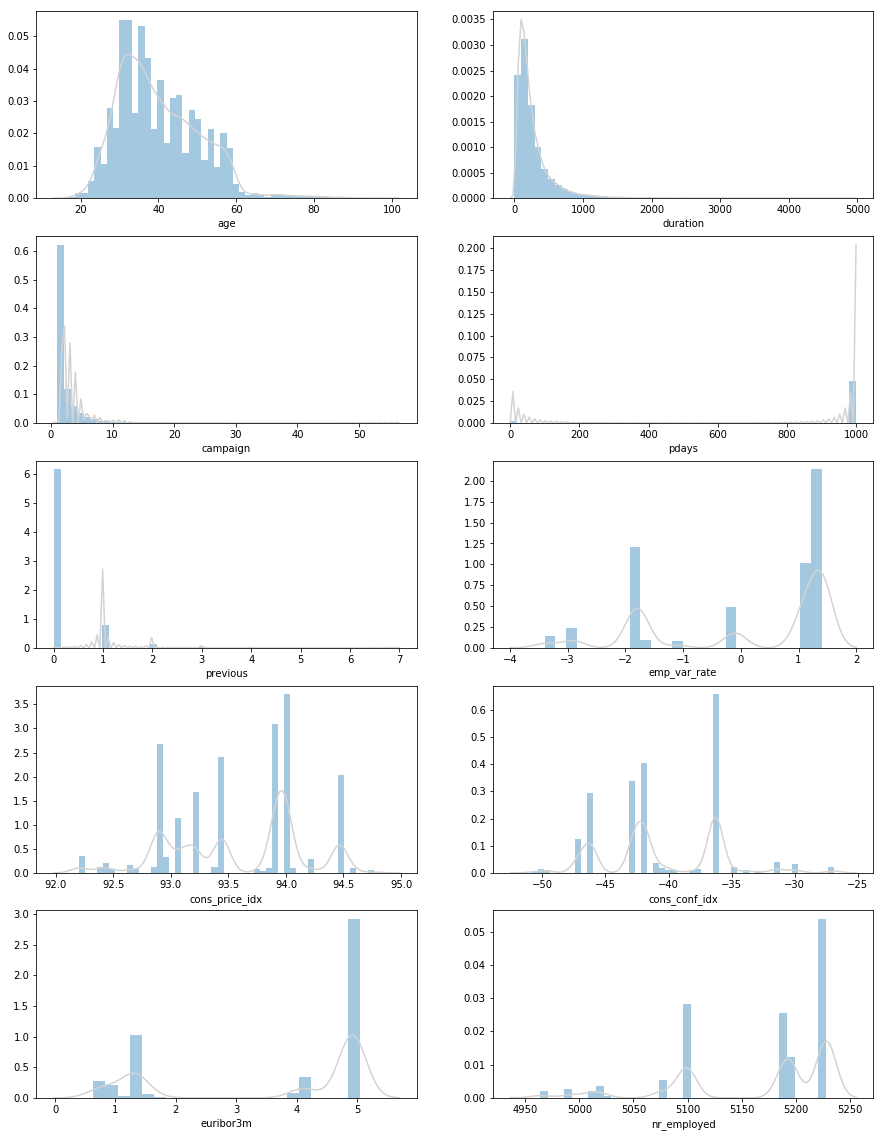

In [140]:
df_num = df.drop(list(col_object) + ['y'], axis=1)

fig, ax = plt.subplots(5,2, figsize=(15,20))
for i, col in enumerate(df_num,start=1):
    plt.subplot(5,2,i)
    sns.distplot(df_num[col],kde_kws={'color':'lightgrey'})

Let's note some observations for these features:
- **age**
    - distribution seems quite close to normal, ranges between 17 and 98, but most values between 20 and 60 years
- **duration:** last contact duration, in seconds (numeric)
    - is strongly left-skewed, but should anyways be dropped for model (see above)
- **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - ranges between 1 and 56, but most values are below 10 (strongly left-skewed)
- **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 = client was not previously contacted)
  - we have to replace the 999 by NaN (otherwise they will be interpreted in a numeric way) --> see below
  - after doing this, we see that the feature ranges between 0 and 30, but is left-skewed
- **previous:** number of contacts performed before this campaign and for this client (numeric)
  - ranges between 0 and 7, but is mostly zero (strongly left-skewed)
- **emp.var.rate:** employment variation rate — (numeric)
  - ranges between -3.4 and 1.4, most frequent value is 1.4
- **cons.price.idx:** consumer price index — (numeric)
  - ranges between 92 and 95
- **cons.conf.idx:** consumer confidence index — (numeric)
  - ranges between -50 and -25
- **euribor3m:** euribor 3 month rate — (numeric)
  - ranges between 0 and 5, with 5 being the most frequent value
- **nr.employed:** number of employees — (numeric)
  - ranges between 4950 and 5250

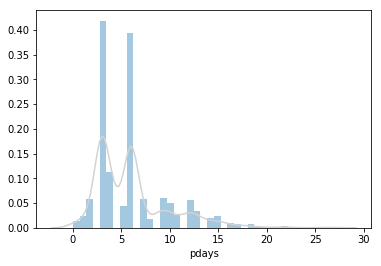

In [159]:
# pdays: replace 999 with NaN, then plot the histogram again
#df.pdays.value_counts().sort_index(ascending=False)
df_num.pdays[df_num.pdays==999] = np.nan
sns.distplot(df_num.pdays[df_num.pdays.notna()],kde_kws={'color':'lightgrey'});

### Numerical features: Heatmap

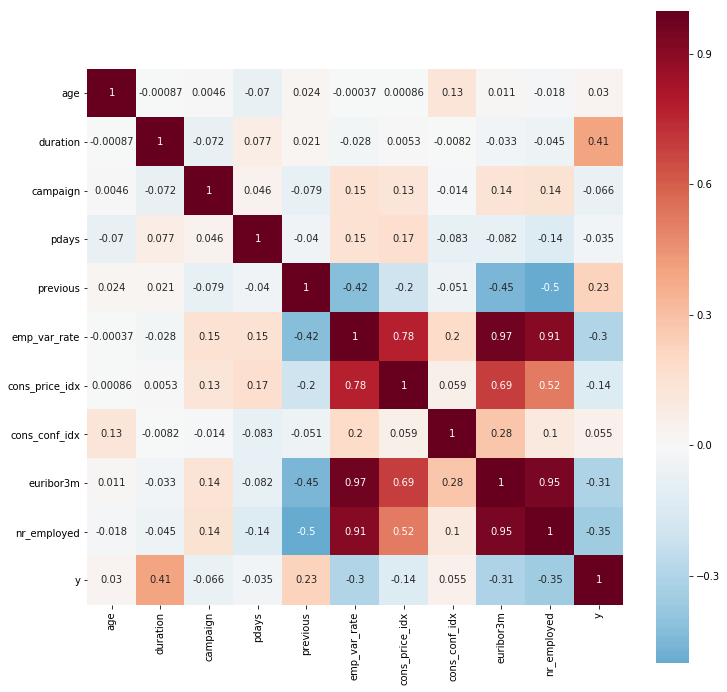

In [170]:
# Heatmap (correlation matrix) of numerical variables with response variable
df_heatmap = pd.concat([df_num, df.y], axis=1)
corr_matrix = df_heatmap.corr()

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, cmap='RdBu_r', square=True, center=0, annot=True);

**Observations:**
- We see that the response variable `y` has the highest positive correlation with `duration` (0.41)- however, we planned to not include this feature in the model (see dataset description above).
- We also see that `y` has a moderate *positive* correlation with `previous` (0.23) and a moderate *negative* correlation with `nr_employed` (-0.35), `euribor3m` (-0.31), and `emp_var_rate` (-0.3). However, we also see that these three variables are strongly correlated (>0.9), hence we should not include all three of these in the final model if we want to avoid multicollinearity.

In [177]:
# show correlation coefficients of all features with our (binary) response variable y, sorted by absolute value
k = 5
corr_matrix.y.abs().sort_values(ascending=False)

y                 1.000000
duration          0.405274
nr_employed       0.354678
euribor3m         0.307771
emp_var_rate      0.298334
previous          0.230181
cons_price_idx    0.136211
campaign          0.066357
cons_conf_idx     0.054878
pdays             0.035223
age               0.030399
Name: y, dtype: float64

In [178]:
# pick the features with the largest absolute correlations with our (binary) response variable y
k = 5
corr_matrix.y.abs().sort_values(ascending=False)[1:k+1]

duration        0.405274
nr_employed     0.354678
euribor3m       0.307771
emp_var_rate    0.298334
previous        0.230181
Name: y, dtype: float64

### Categorical features: Heatmap

For a quick overview, let's plot a heatmap including the response variable y and all dummy variables

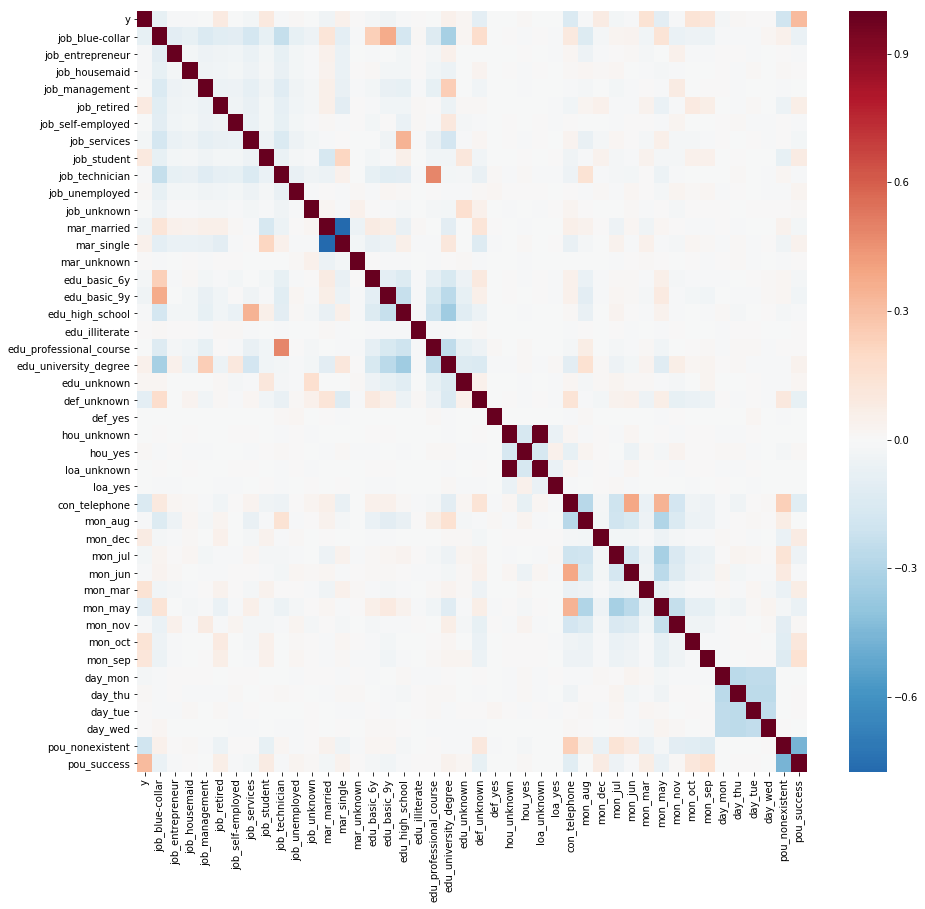

In [194]:
# Heatmap (correlation analysis) with all dummy variables

corr_matrix_dummies = df_dummies.corr()

fig, ax = plt.subplots(figsize=(15,14))
sns.heatmap(corr_matrix_dummies, cmap='RdBu_r', center=0); #, annot=True);

We see that the strongest positive relationship exists between the response variable `y` and the variable `pou_success`, which is a dummy-variable that encodes whether the outcome of the previous marketing campaign was a success (1) or not (0).

---
## 4) Logistic Regression

In [208]:
# dependent variable
y = df.y

# independent variables (both numerical and categorical)
    # We will drop `pdays`, as it has many missing values and shows not even a moderate correlation with y.
    # We will also drop `duration` (see above for why we are dropping it)
X = pd.concat([df_num.drop(['duration','pdays'],axis=1), df_dummies.drop(['y'],axis=1)], axis=1)

X.head(3)

,age,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,mar_married,mar_single,mar_unknown,edu_basic_6y,edu_basic_9y,edu_high_school,...,edu_professional_course,edu_university_degree,edu_unknown,def_unknown,def_yes,hou_unknown,hou_yes,loa_unknown,loa_yes,con_telephone,mon_aug,mon_dec,mon_jul,mon_jun,mon_mar,mon_may,mon_nov,mon_oct,mon_sep,day_mon,day_thu,day_tue,day_wed,pou_nonexistent,pou_success
0,44,1,0,1.4,93.444,-36.1,4.963,5228.1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,53,1,0,-0.1,93.200,-42.0,4.021,5195.8,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,28,3,2,-1.7,94.055,-39.8,0.729,4991.6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [210]:
# Prior to training our model, we’ll set aside a portion of our data in order to evaluate its performance

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30891, 51), (10297, 51), (30891,), (10297,))

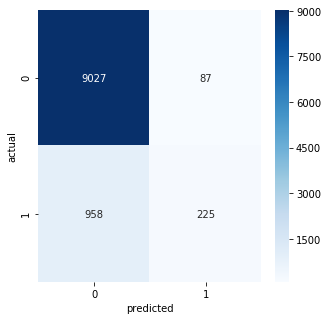

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      9114
           1       0.72      0.19      0.30      1183

    accuracy                           0.90     10297
   macro avg       0.81      0.59      0.62     10297
weighted avg       0.88      0.90      0.87     10297



In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# instatiate and fit the Logistic Regression model
logr = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr.fit(X_train, y_train)

# make predictions for test set
y_pred = logr.predict(X_test)
y_pred_proba = logr.predict_proba(X_test)

# calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)  # tn, fp, fn, tp
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0f');  # use fmt to suppress scientific notation
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show(); 

# show full classification report below
print(classification_report(y_test, y_pred))

In [213]:
# calculate accuracy using sklearn metrics [ Accuracy = (TP + TN) / (TP + TN + FP + FN) ]
print('Accuracy: ', accuracy_score(y_test, y_pred).round(3))

Accuracy:  0.899
